<div style="text-align: center;">

# **Algoritmia Cuantica** 
# Estimacion de Fase   
<font size="2">

##### Daniel Amauri Vázquez Gutiérrez
</font>

En este documento resumire la teoria  lo mejor posible para poder entender la estimacion de fase si se requiere retomar en el futuro. Ademas,**el programa ya esta mucho mas pulido de lo que se tenia como primera version**.  

Nuesto objetivo general es, apartir de un operador unitario conocido, $U$  y un eigevector $|\psi\rangle $ conocido de $U$, conocer la fase $\theta$  del eigenvalor de  $|\psi \rangle$ , donde sabemos que el eigenvalor tiene la forma : 
$$ U |\psi\rangle = \lambda |\psi\rangle = e^{2\pi i \theta   } |\psi\rangle $$

Solo recordando que una de las caracteristicas de los operadores unitarios es que sus eigenvectores **tienen  eigenvalores con modulo igual a 1**, esto es :  
$$ |\lambda|=1$$


Para lograr esto emplearemos dos grupos de qbits, unos *qbits de presicion* que nos dara el valor de $\theta$  ( mientras mayor cantidad de estos se tengan , mas presiza sera nuestra estimacion) , y el otro seran los qbits que representaran los eigenvectores de nuestro operador unitario $U$, por lo que los llamaremos *eigen-qbits*.

Entonces, comenzamos con nuestro primer estado :  
$$|\Psi _0 \rangle = |0\rangle^{\otimes m}|\psi\rangle $$ 

Donde aqui tenemos $m$ qbits de presicion  y tenemos el eigenvector conocido $|\psi \rangle$ . Luego , obtenemos una superpoision de estados  empleando la compuerta de Hadamard  , en los qbits de presicion. 

$$|\Psi _1 \rangle = (H^{\otimes m}\otimes I_m )|\Psi _0 \rangle = \frac{1}{2^\frac{m}{2}}(|0\rangle+|1\rangle)^{\otimes m}|\psi\rangle =\frac{1}{2^\frac{m}{2}}\sum^{2^m-1}_{j=0}|j\rangle |\psi\rangle $$  

Esta superposicion de n qbits produce  una sumatoria de productos tensoriales cuyo orden en binario son los numeros del 0 al $2^n-1$ .  Nesesitamos una forma en la que los *qbits de presicion* se vean modificados por los *eigen-qbits*, por lo que hacemos nuestro operador Unitario $U$ en un operador unitario controlado $U_C$ , sabiendo en primer lugar que :

 

$$U_C= \sum^{2^m-1}_{k=0} |k\rangle \langle k | \otimes U^k $$

Ahora , si aplicamos $U_C$  , entonces $ |\psi_1 \rangle $   : 

$$|\psi_2 \rangle =U_C |\psi_1 \rangle = \Big( \frac{1}{2^{\frac{m}{2}}}\sum^{2^m-1}_{k=0} e^{2\pi i \theta k}|k\rangle  \Big) \otimes |\psi \rangle $$ 

Cuya estructura nos sirve muchisimo ya que es muy analoga a la $QFT$ . Pero antes de desarrollar esa parte , primero **veamos  como podemos aplicar  computacionalmente correctamente  esta compuerta**, cosa que no es para nada trivial .

Mostraremos ahora que : 

$$U_C = \prod^{m-1}_{l=0} C_l ( U^{2^l})$$

Donde primero definimos  lo que hace la operacion $C(U^k)$ , de esta forma los vamos a definir de la siguiente manera : 
$$ C_l( U^k)(|j\rangle \otimes |\psi \rangle)= |j\rangle \otimes (U^{j_l k }|\psi \rangle )$$

Donde $|j\rangle $ es producto tensorial  donde j es un numero entre  $2^m -1 $ al $0$ . Por otro lado, $j_l$ es  el $l$-esimo digito (o qbit) que compone $j$ en binario ,por lo que $j_l \epsilon \{ 0,1\}$ . Al aplicar $ C_l$, si  $j_l$ es 0 se queda igual , si es 1 se aplica  el operador $k$ veces .  

Con esto podemos desarrollar  lo siguiente : 

$$ \prod^{m-1}_{l=0} C_l ( U^{2^l}) (|j\rangle \otimes |\psi \rangle) = |j\rangle \otimes \Big(U^{\sum^{m-1}_{l=0} j_l 2^l }|\psi \rangle \Big)= |j\rangle \otimes   U^j |\psi\rangle=  U_C (|j\rangle \otimes |\psi\rangle)  $$ 

Donde unicamente notamos lo siguiente : 

$$j=\sum^{m-1}_{l=0} j_l 2^l $$
 Siendo esta la descomposicion binaria . Por lo tanto :

 $$U_C = \prod^{m-1}_{l=0} C_l ( U^{2^l})$$ 

 

 Con esto podemos aplicar compuertas controladas de forma directa  siguiendo esta ecuacion. 

In [1]:
#Bloque de importacion
import numpy as np 
import math
from qiskit import QuantumCircuit, transpile, assemble
from qiskit_aer import Aer #Aer es un modulo de Qiskit que proporciona simuladores cuanticos para ejecutarlos de manera local.  
from qiskit.quantum_info import Statevector,DensityMatrix
from qiskit.visualization import plot_histogram,plot_bloch_multivector
from qiskit.circuit import Gate
from qiskit.circuit.library import *

import qiskit 
print(qiskit.version.get_version_info()) 

1.2.0


Ahora recordamos la estructura de la $QFT$ : 

$$QFT |x \rangle = \frac{1}{2^{\frac{n}{2}}}\sum^{2^n-1}_{y=0}e^{\frac{2\pi i xy}{2^n}}|y\rangle$$  

Que tiene la misma estructura que  tiene el primer miembro de $|\psi_2 \rangle $ ,luego : 
$$ \theta = \frac{x}{2^n} $$

Por tanto , aplicando la $IQFT$, obtenendremos el numero  en binario $|x\rangle$  al medir los *qbits de presicion*  .  

$$\psi_3\rangle = (IQFT \otimes I ) |\psi_2\rangle = |x\rangle \otimes  |\psi \rangle $$

 Tranformamos el valor de $|x\rangle $ a decimal  y con ello  encontramos  lo siguiente:  

$$ \theta = \frac{x_{10}}{2^n} $$

Lo cual podemos encontrar clasicamente. 

Con esto , estamos en condiciones de aplicar nuestro algoritmo. 

In [4]:
#Transformada Cuantica de Fourier Inversa  

class IQFT(Gate):
    def __init__(self, s):
        # n es el numero que será representado en binario, s es el número de qubits
        super().__init__('IQFT_CUSTOM', s, [])  # La etiqueta de la compuerta y el número de qubits
        self.s = s
        

    def _define(self):
         qc = QuantumCircuit(self.s)
 
         #Primero volvemos a Switchear 
         if self.s % 2 == 1:
               for l in range((self.s - 1) // 2):
                  qc.swap(l, self.s - 1 - l)
         else:
               for l in range(self.s // 2):
                  qc.swap(l, self.s - 1 - l)


            #Volvemos a añadir las compuertas pero ahora en un sentido invertido 

         for j in range(self.s):  
               qc.h(j)

               if j<(self.s-1):
                  for k in range(j+1):
                     qc.cp(2*np.pi/(-2**(k+2)),j+1,j-k)   

         
            #Agragamos este SWAP que no deberia ser nesesario , sin embargo , lo ponemos dado que esto nos permite ver los estados de los Qbits en un orden
            #usal en el que vemos los numeros binarios y asi poderlo comparar con el arreglo original que producimos al inicializar el circuito. 

         
         self.definition = qc  


In [5]:
# SWAP  cumtomizado  
class SWAP(Gate):
    def __init__(self, s):
        # n es el numero que será representado en binario, s es el número de qubits
        super().__init__('SWAP_CUSTOM', s, [])  # La etiqueta de la compuerta y el número de qubits
        self.s = s
        

    def _define(self):
         qc = QuantumCircuit(self.s)
 
         #Primero volvemos a Switchear 
         if self.s % 2 == 1:
               for l in range((self.s - 1) // 2):
                  qc.swap(l, self.s - 1 - l)
         else:
               for l in range(self.s // 2):
                  qc.swap(l, self.s - 1 - l)


         
         self.definition = qc  


In [149]:
n=int(input("Ingresa un numero natural de n bits de nuestro Eigenvector : ")) 

Normalmente la estimacion de fase se aplica unicamente a compuertas de rotacion , asi como a  operadores de evolucion temporal  en simulacion cuantica de sistemas fisicos. Por el momento solo nos enfocaremos en la rotacion,  , por lo que establecemos aqui un $\theta$ a ser obtenido al final. 

In [150]:
theta=1/3

In [157]:
m=int(input("Ingresa un numero natural de m bits de  presición: "))  


qc = QuantumCircuit(m+n,m) # El mas uno lo usaremos como acarreo 

#Indicamos grupos de Qbits 
numero_EIGEN = list(range(m, m+n))  #Qbits del eigenvector
numero_ACURA = list(range(0, m))   #Qbits de presicion  

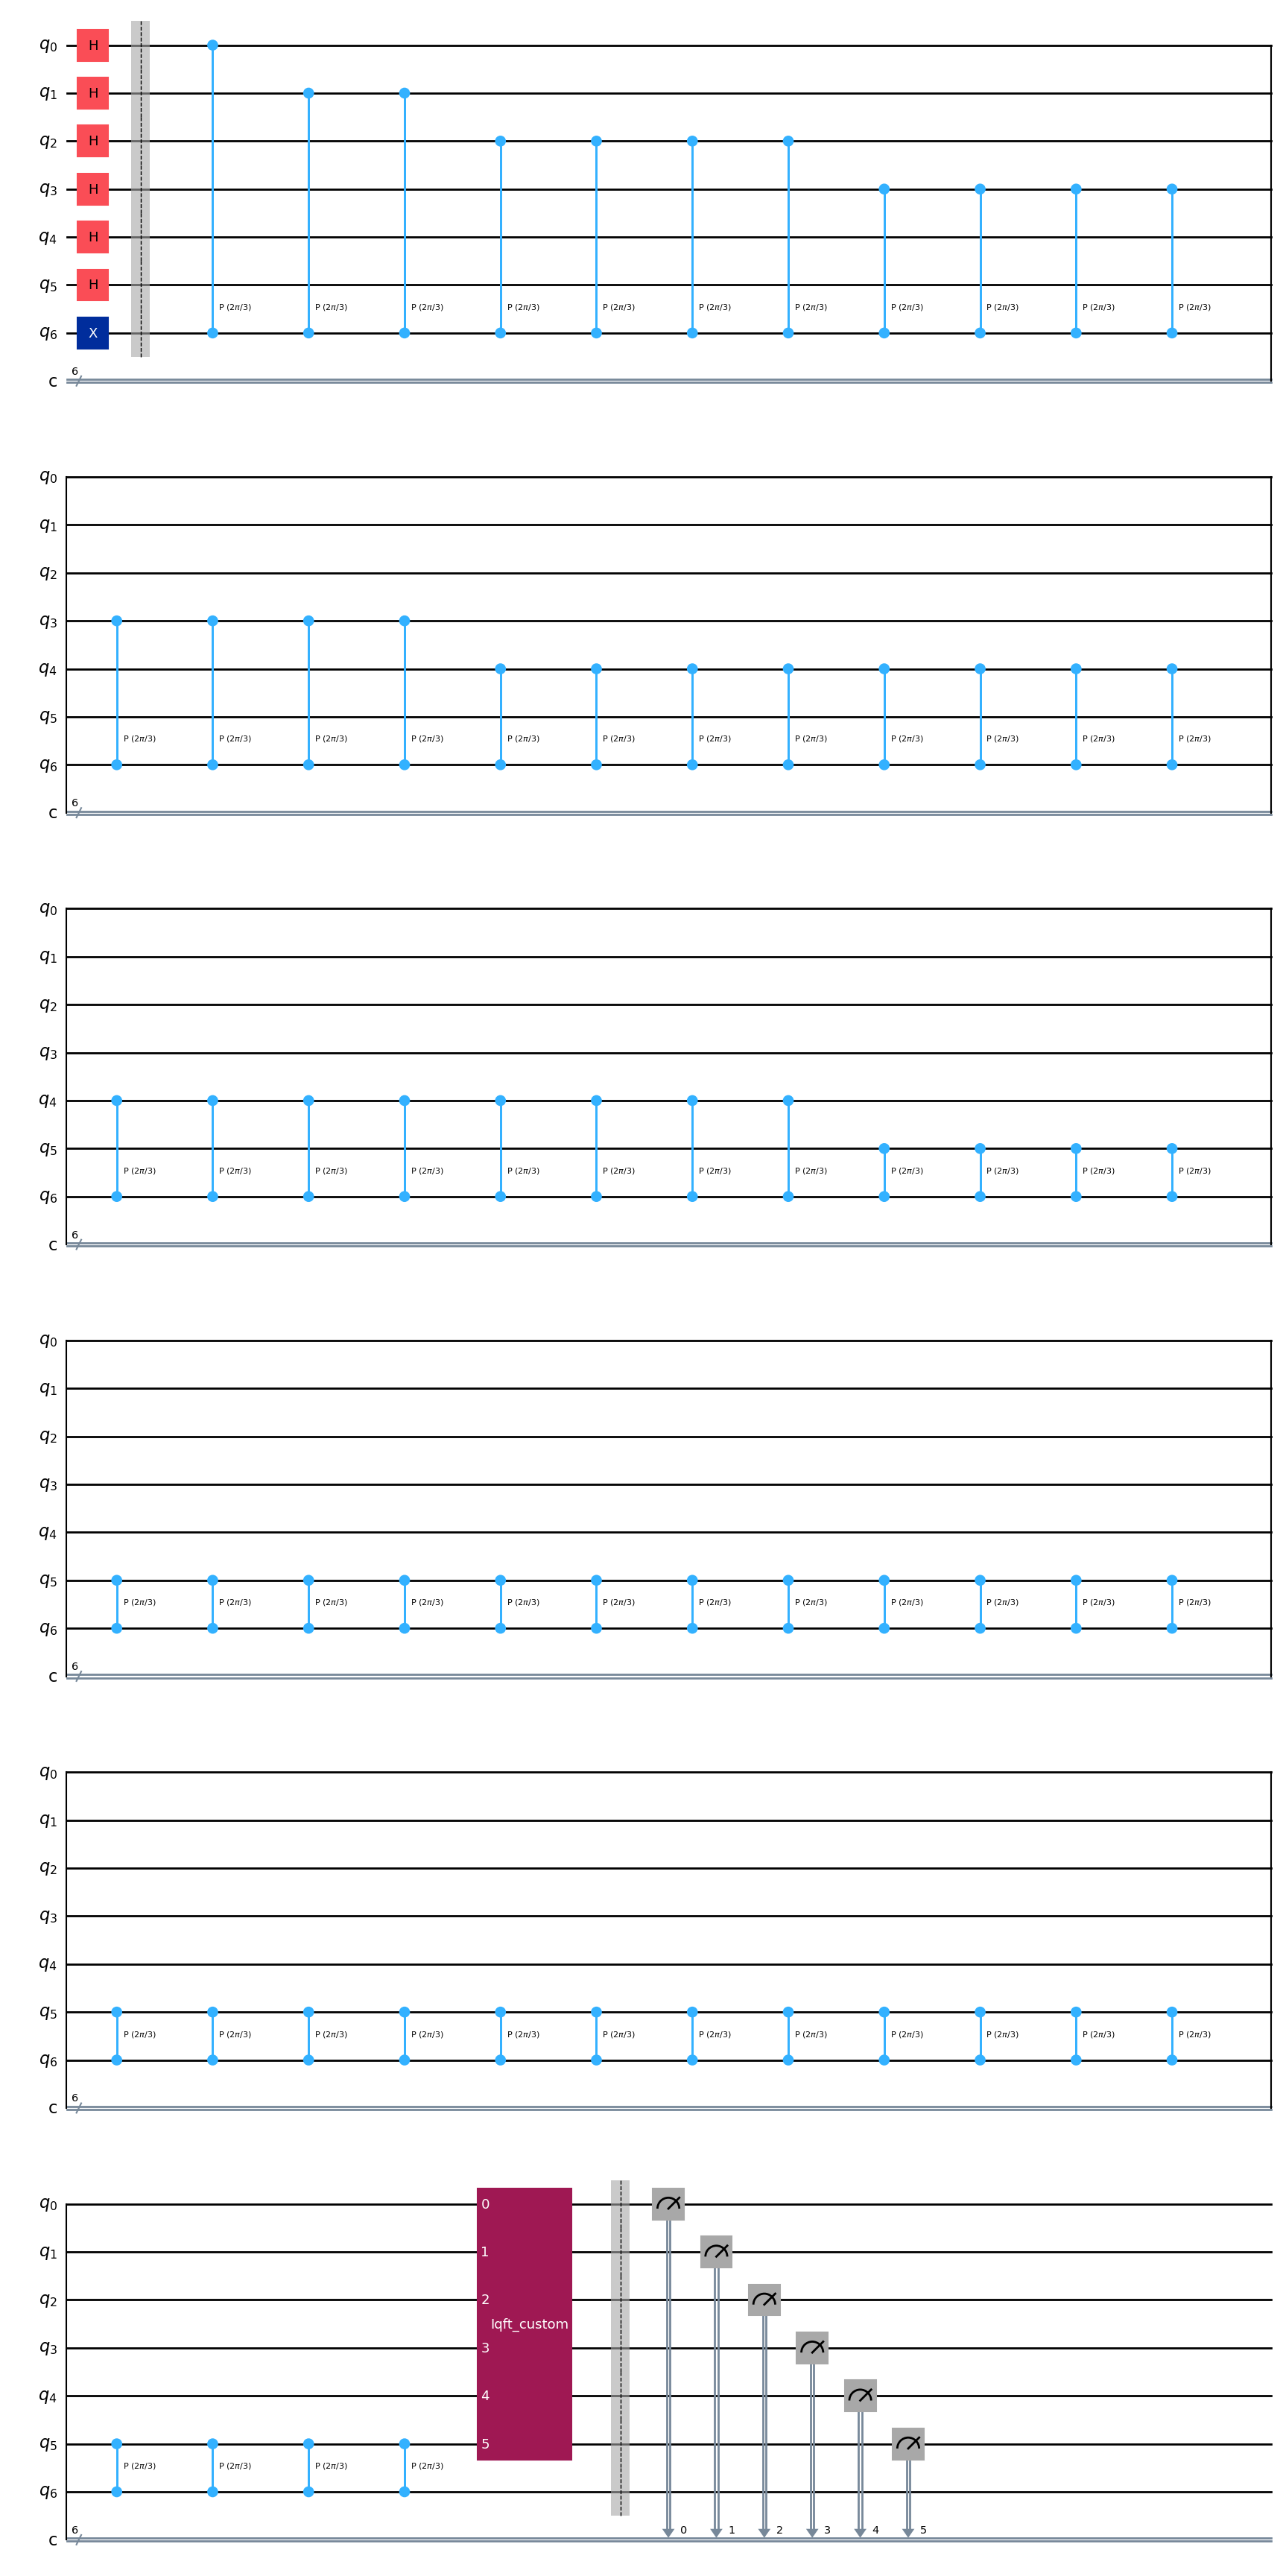

In [158]:
  

#Aplicamos compuertas de hadamard en los qbits de precision
for j in numero_ACURA:  
   qc.h(j)   

#Ahora inicializaremos con unos los Eigenvectores PERO SOLO ES  ESPECIFICAMENTE  EN  EL CASO DE LOS OPERADORES DE ROTACION CONTROLADA. 
for j in numero_EIGEN:  
   qc.x(j)  


iqft_1=IQFT(m)  
qc.barrier()

# Aplicamos las operaciones controladas U^j
w=0
for j in numero_ACURA:
      for i in range(2**w):#aplica la compuerta controlada w numero de veces , con w el numero de posicion del qbit de presicion
         qc.cp(2*np.pi*theta, j, numero_EIGEN)
      
      w=w+1



qc.append(iqft_1, numero_ACURA)   
#qc.append(SWAP(m),numero_ACURA) #Nesesario por el como se  aplicaran las compuertas de rotacion posteriormente. 
#Podriamos evitar este ultimo paso , sin embargo , tendria que modificar mi compuerta QFT original , y la idea  es que esta se mantenga intacta . 
qc.barrier()
# Medimos los qubits
qc.measure(range(m), range(m))

qc.draw('mpl')


Como estamos corriendo en una simulacion cuantica, muchas veces los efectos de error probocaran que unsa sola medicion no vaste, por lo que devemos de tomar muchas muestras para poder  estimar correctamente  los estados que estamos determinando probabilisticamente. 

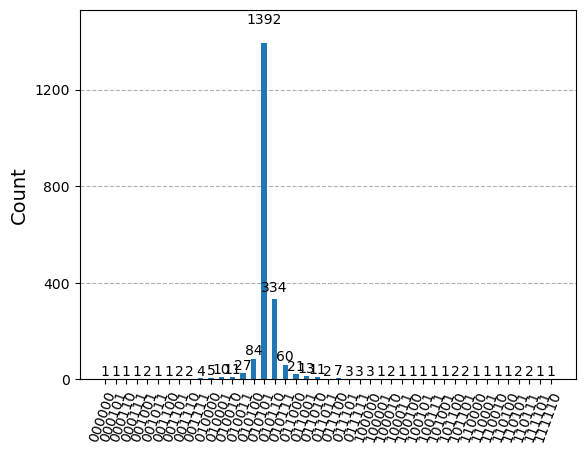

In [159]:
#------Obtencion del histograma ----------------

backend=Aer.get_backend('qasm_simulator')  
#podemos cambiar a 'qasm_simulator' , ya que 'statevector_simulator' no es compatible con mediciones clasicas

compilado=transpile(qc, backend)  
#transpile es una funcion que optimiza el circuito cuantico para que sea compatible con el backend seleccionado. 

job=backend.run(compilado, shots=2024)  
#Ejecutamos el circuito cuantico 
#Shots, especifica cuantas veces se ejecuta el circuito cuantico ( recordemos que la cuantica es probabilistica)

result=job.result() #Obtiene los resultados del lo anterior

# Graficamos el histograma de resultados
plot_histogram(result.get_counts()) 

Ahora , partir de los datos , obtenemos  el estado que mas veces medimos y este lo tomaremos como nuestro $|x\rangle$ , y en funcion de este obtenemos nuestro $\theta$ 

In [160]:
counts = result.get_counts()
# Encuentra el valor más obtenido
valor_mas_obtenido = max(counts, key=counts.get)
cuenta_maxima = counts[valor_mas_obtenido] 
# Convertir el valor más obtenido de binario a decimal
valor_decimal = int(valor_mas_obtenido, 2)

print(f"El valor más obtenido en binario es: {valor_mas_obtenido} con {cuenta_maxima} veces.") 
print(f"El valor más obtenido en decimal  es: {valor_decimal} con {cuenta_maxima} veces.")

El valor más obtenido en binario es: 010101 con 1392 veces.
El valor más obtenido en decimal  es: 21 con 1392 veces.


In [161]:
# Convertir el valor más obtenido de binario a decimal
valor_decimal = int(valor_mas_obtenido, 2)

Fase_estimada=valor_decimal/2**m 

error_relativo=abs((theta-Fase_estimada)/theta)  

# Imprimimos resultados
print(f"Fase estimada: {Fase_estimada}")
print(f"Error relativo: {error_relativo}")


Fase estimada: 0.328125
Error relativo: 0.015624999999999944
